<a href="https://colab.research.google.com/github/Himanshu0518/NLP/blob/main/sentiment_analysis_on_IMDB_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d vishakhdapat/imdb-movie-reviews

Dataset URL: https://www.kaggle.com/datasets/vishakhdapat/imdb-movie-reviews
License(s): MIT
 66% 17.0M/25.7M [00:00<00:00, 62.4MB/s]
100% 25.7M/25.7M [00:00<00:00, 86.2MB/s]


In [ ]:
from zipfile import ZipFile
dataset = '/content/imdb-movie-reviews.zip'
with ZipFile(dataset, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [119]:
df = pd.read_csv('/content/imdb-movie-reviews.zip')

In [74]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [120]:
import string
# removing the html tags
def clean_html(text):
    clean=re.compile('<.*?>')
    cleantext=re.sub(clean,'',text)
    return cleantext

# first round of cleaning
def clean_text1(text):
    text=text.lower()
    text=re.sub('\[.*?\]','',text)
    text=re.sub('[%s]'%re.escape(string.punctuation),'',text)
    text=re.sub('\w*\d\w*','',text)
    return text

# second round of cleaning
def clean_text2(text):
    text=re.sub('[''"",,,]','',text)
    text=re.sub('\n','',text)
    return text

cleaned_html=lambda x:clean_html(x)
cleaned1=lambda x:clean_text1(x)
cleaned2=lambda x:clean_text2(x)

df['review']=pd.DataFrame(df.review.apply(cleaned_html))
df['review']=pd.DataFrame(df.review.apply(cleaned1))
df['review']=pd.DataFrame(df.review.apply(cleaned2))

In [121]:
df.columns = ['text','sentiments']

In [122]:
df.head()

,text,sentiments
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production the filming tech...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically theres a family where a little boy j...,negative
4,petter matteis love in the time of money is a ...,positive


In [ ]:
df.isnull().sum()

,0
text,0
sentiments,0


In [ ]:
df.shape

(50000, 2)

In [ ]:
df['sentiments'].value_counts()

,count
sentiments,
positive,25000
negative,25000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        50000 non-null  object
 1   sentiments  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
df['sentiments'] = df['sentiments'].replace({'positive':1,'negative':0})

In [ ]:
df.head()

,text,sentiments
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [ ]:
import nltk
from nltk.corpus import stopwords
import re
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [78]:
def lemmatizing(content):
    content = re.sub('\[[^]]*\]', '', content)
    text = re.sub(r"http\S+", "", content)
    content = re.sub('[^a-zA-Z0-9]',' ',content)
    content = re.sub(r'<br\s*/?>', '', content)
    content = content.lower()
    content = content.split()
    content = [lemmatizer.lemmatize(word) for word in content if not word in stopwords.words('english')]
    content = ' '.join(content)
    return content

In [79]:
df['text'] = df['text'].apply(lemmatizing)

In [81]:
X = df['text'].values
Y = df['sentiments'].values

In [82]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.layers import Bidirectional

In [83]:
vocab_size = 5000

## One hot Representation

In [84]:
message = X.copy()

In [85]:
onehot_rep = [one_hot(words,vocab_size) for words in message]

In [86]:
print(message[0])

one reviewer mentioned watching oz episode hooked right exactly happened br br first thing struck oz brutality unflinching scene violence set right word go trust show faint hearted timid show pull punch regard drug sex violence hardcore classic use word br br called oz nickname given oswald maximum security state penitentary focus mainly emerald city experimental section prison cell glass front face inwards privacy high agenda em city home many aryan muslim gangsta latino christian italian irish scuffle death stare dodgy dealing shady agreement never far away br br would say main appeal show due fact go show dare forget pretty picture painted mainstream audience forget charm forget romance oz mess around first episode ever saw struck nasty surreal say ready watched developed taste oz got accustomed high level graphic violence violence injustice crooked guard sold nickel inmate kill order get away well mannered middle class inmate turned prison bitch due lack street skill prison experie

In [87]:
sent_length = 30
embedded_docs = pad_sequences(onehot_rep,padding='pre',maxlen=sent_length)

In [88]:
print(embedded_docs[0])
print(type(embedded_docs[0]))

[  99 1865 1133 2664  631 1727 1715 4786 1825 1815 3826 1826 1272  885
 4636 2450 3826 1787  431 2461 3643  875 3318  380 4094 3694 1133 2262
 4654 3295]
<class 'numpy.ndarray'>


In [89]:
# Creating the model
embedding_vector_features = 40
model = Sequential()
model.add(Embedding(vocab_size,embedding_vector_features,input_length=sent_length))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(100)))
model.add(Dropout(0.2))
model.add(Dense(1,activation = 'sigmoid'))
model.compile(loss='binary_crossentropy' , optimizer = 'adam' , metrics =['accuracy'])

# Build the model by specifying the input shape
model.build((None, sent_length))

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 30, 40)              │         200,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 30, 40)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 200)                 │         112,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 313,001 (1.19 MB)

 Trainable params: 313,001 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

In [90]:
X_final = np.array(embedded_docs)
Y_final = np.array(Y)

In [91]:
train_data,test_data,train_label,test_label = train_test_split(X_final,Y_final,test_size=0.1,random_state = 4)

In [92]:
model_history = model.fit(train_data,train_label,validation_data=(test_data,test_label),epochs=3,batch_size=32)

Epoch 1/3
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 87s 59ms/step - accuracy: 0.7269 - loss: 0.5217 - val_accuracy: 0.7912 - val_loss: 0.4375
Epoch 2/3
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 130s 51ms/step - accuracy: 0.8205 - loss: 0.4028 - val_accuracy: 0.7982 - val_loss: 0.4383
Epoch 3/3
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 72s 51ms/step - accuracy: 0.8428 - loss: 0.3641 - val_accuracy: 0.8000 - val_loss: 0.4358


In [93]:
y_pred = model.predict(test_data)

157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step


In [94]:
original_df = pd.read_csv('/content/imdb-movie-reviews.zip')

In [95]:
from sklearn.metrics import confusion_matrix,accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [96]:
y_pred = np.where(y_pred >= 0.5,1,0)

In [97]:
accuracy_score(y_pred,test_label)

0.8

In [98]:
confusion_matrix(y_pred,test_label)

array([[1975,  486],
       [ 514, 2025]])

In [99]:
# Access training and validation accuracy
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

# Access training and validation loss
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']


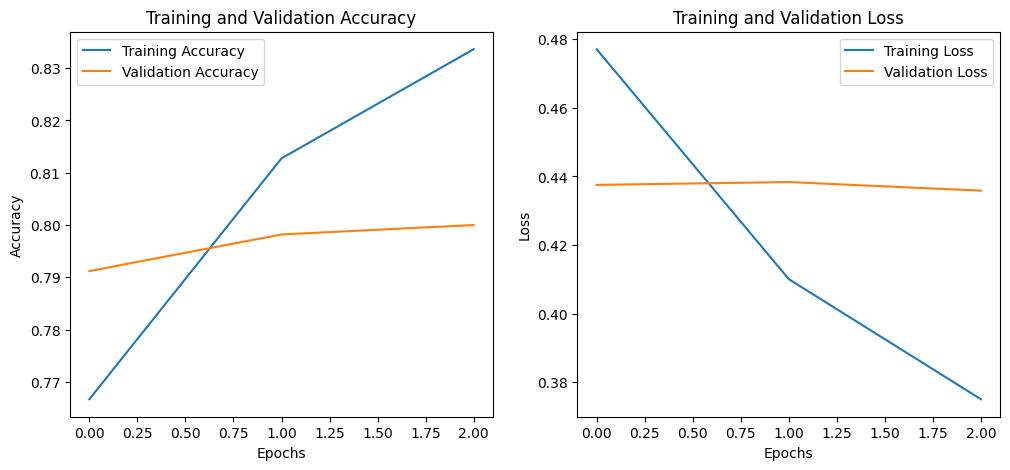

In [100]:

# Plot accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
import pickle

In [ ]:
config = {
    'vocab_size': vocab_size,
    'sent_length': sent_length,
    'word_index': {}  # If using a specific word index, save it here
}

In [ ]:
with open('config_IMDB', 'wb') as f:
    pickle.dump(config, f)

In [ ]:
model.save('IMDB_reviews_model.keras')

In [ ]:
def predict(text):
   text = lemmatizing(text)
   onehot_rep = [one_hot(text,vocab_size)]
   embedded_docs = pad_sequences(onehot_rep,padding='pre',maxlen=sent_length)
   prediction = model.predict(embedded_docs)
   print(prediction)
   if prediction >= 0.5:
     return 'Positive'
   else:
     return 'Negative'

In [103]:
def predict(text):
   text = lemmatizing(text)
   onehot_rep = [one_hot(text,vocab_size)]
   embedded_docs = pad_sequences(onehot_rep,padding='pre',maxlen=sent_length)
   prediction = model.predict(embedded_docs)
   print(prediction)
   if prediction >= 0.5:
     return 'Positive'
   else:
     return 'Negative'

In [71]:
review = original_df.iloc[0]['review']
review

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [72]:
review = original_df.iloc[10]['review']
review

'Phil the Alien is one of those quirky films where the humour is based around the oddness of everything rather than actual punchlines.<br /><br />At first it was very odd and pretty funny but as the movie progressed I didn\'t find the jokes or oddness funny anymore.<br /><br />Its a low budget film (thats never a problem in itself), there were some pretty interesting characters, but eventually I just lost interest.<br /><br />I imagine this film would appeal to a stoner who is currently partaking.<br /><br />For something similar but better try "Brother from another planet"'

In [115]:
review = original_df.iloc[10]['review']
review

'Phil the Alien is one of those quirky films where the humour is based around the oddness of everything rather than actual punchlines.<br /><br />At first it was very odd and pretty funny but as the movie progressed I didn\'t find the jokes or oddness funny anymore.<br /><br />Its a low budget film (thats never a problem in itself), there were some pretty interesting characters, but eventually I just lost interest.<br /><br />I imagine this film would appeal to a stoner who is currently partaking.<br /><br />For something similar but better try "Brother from another planet"'

In [116]:
re.sub(r'<br\s*/?>', '', review)

'Phil the Alien is one of those quirky films where the humour is based around the oddness of everything rather than actual punchlines.At first it was very odd and pretty funny but as the movie progressed I didn\'t find the jokes or oddness funny anymore.Its a low budget film (thats never a problem in itself), there were some pretty interesting characters, but eventually I just lost interest.I imagine this film would appeal to a stoner who is currently partaking.For something similar but better try "Brother from another planet"'

In [101]:
df.iloc[0]['sentiments']

1

In [111]:
review = original_df.iloc[500]['review']

In [112]:
predict(review)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[[0.2485095]]


'Negative'

In [113]:
df.iloc[500]['sentiments']

0

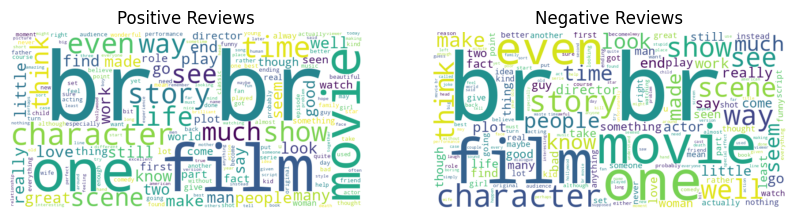

In [114]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filter for positive and negative reviews
positive = df[df['sentiments'] == 1]
negative = df[df['sentiments'] == 0]

Positive_reviews = ' '.join(positive['text'])
Negative_reviews = ' '.join(negative['text'])

wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(Positive_reviews)
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(Negative_reviews)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Reviews')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Reviews')

plt.show()